# Bayesian Survival Analysis

**[Original tutorial](https://docs.pymc.io/notebooks/survival_analysis.html)**

Survival analysis studies the distribution of the time to an event.
This tutorial will use data on mastectomy results.

In [79]:
from typing import Callable

import arviz as az
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt
from pymc3.distributions.timeseries import GaussianRandomWalk
from theano import tensor as tt

gg.theme_set(gg.theme_minimal)
%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 601
np.random.seed(RANDOM_SEED)

## Data

Each row in the data represents an observation from a woman diagnosed with breast cancer that underwent a mastectomy.
The column `time` represents the months post-surgery that the woman was observed.
The column `event` indicates whether or not the woman died during the observation period.
The column `metastized` indicates whether the cancer had metastized prior to surgery.

In [2]:
df = pd.read_csv(pm.get_data("mastectomy.csv"))
df["event"] = df.event.astype(np.int64)
df["metastized"] = (df.metastized == "yes").astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

df.head()

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


In [3]:
n_patients

44

## A "crash course" on survival analysis

If the random variable $T$ is the time to the event we are studying, then survival anylsis is concerned with the survival function

$$
S(t) = P(T > t) = 1 - F(t)
$$

where $F$ is the CDF of $T$.
It is convenient the express the survival function in terms of the **hazard rate** $\lambda(t)$: the instantaneous propbability that the event occurs at time $t$ given it has yet to occur.
That is,

$$
\begin{align}
\lambda(t) &= \lim_{\Delta t \to 0} \frac{P(t < T < t + \Delta t | T > t)}{\Delta t} \\
&= \lim_{\Delta t \to 0} \frac{P(t < T < t + \Delta t)}{\Delta t \cdot P(T > t)} \\
&= \frac{1}{S(t)} \cdot \lim_{\Delta t \to 0} \frac{S(t + \Delta t) - S(t)}{\Delta t} = - \frac{S'(t)}{S(t)} \\
\end{align}
$$

Solving this differential equation for the survival function demonstrates

$$
S(t) = \exp \lgroup - \int_{0}^{s} \lambda(s) ds \rgroup
$$

Which in turn shows that the cumulative hazard function

$$
\Lambda(t) = \int_0^t \lambda(s) ds
$$

is an important quantity in survival analysis which we can concisely write as

$$
S(t) = \exp(- \Lambda(t))
$$

An important part of survival analysis is **censoring** because we will not observe the death of every subject.
For our data, the column `event` is 1 if the subject's death ws observed and a 0 is the death was not observed (censored).
The time for a censored data point is *not* the subject's survival time, but, instead, we assume the subject's true survival time exceeds the time point.

In [4]:
df.head()

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


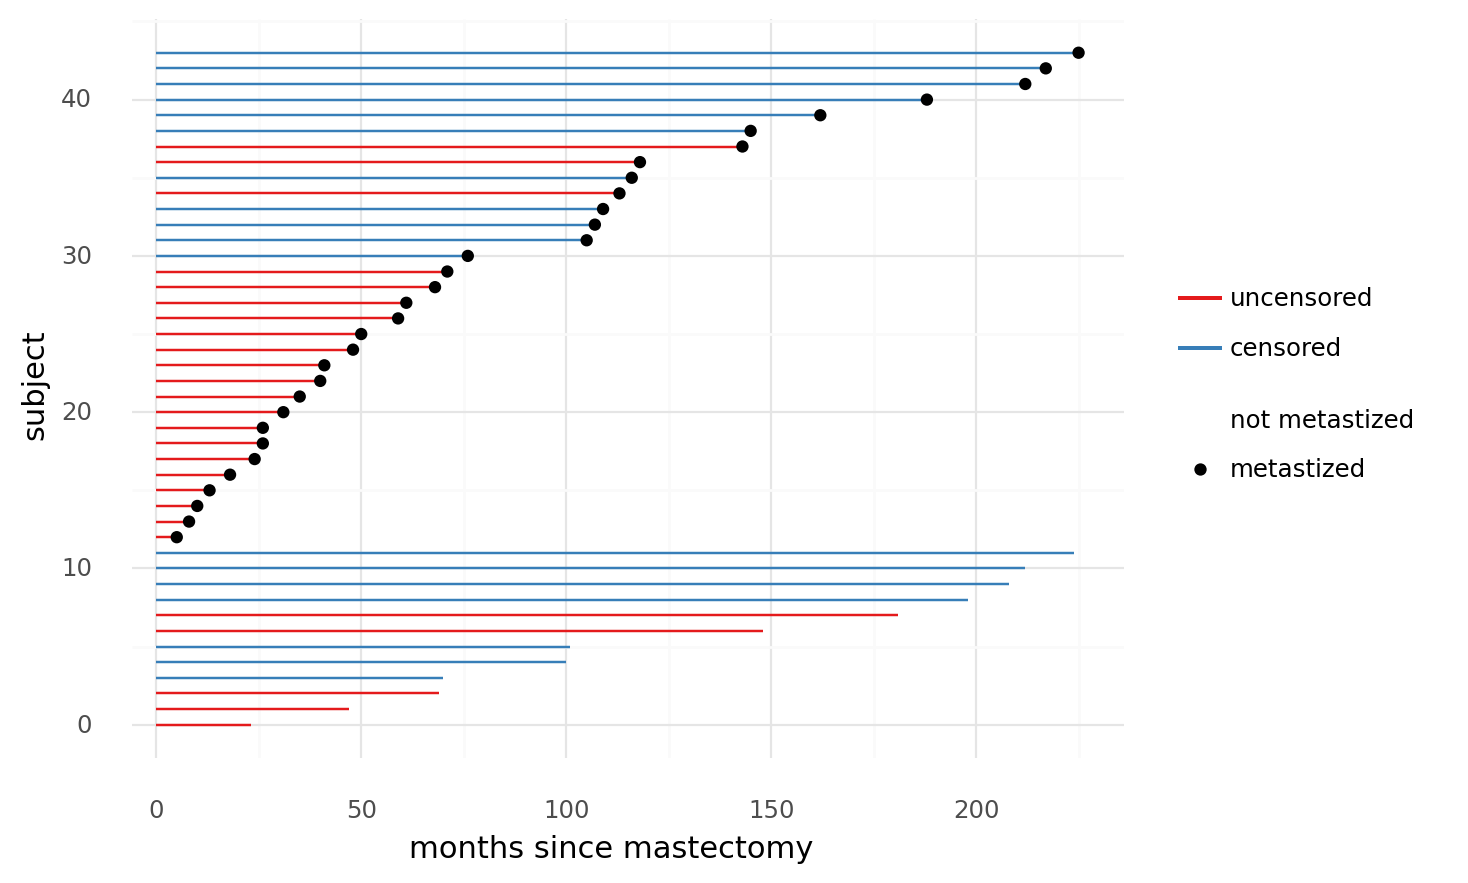

<ggplot: (280873674)>

In [5]:
plot_data = df.copy().reset_index(drop=False).rename(columns={"index": "subject_id"})

(
    gg.ggplot(plot_data, gg.aes(x="subject_id", y="time"))
    + gg.geom_linerange(gg.aes(ymax="time", color="factor(1-event)"), ymin=0)
    + gg.geom_point(gg.aes(alpha="factor(metastized)"))
    + gg.scale_color_brewer(
        type="qual", palette="Set1", labels=("uncensored", "censored")
    )
    + gg.scale_alpha_manual(values=(0, 1), labels=("not metastized", "metastized"))
    + gg.coord_flip()
    + gg.theme(legend_title=gg.element_blank())
    + gg.labs(x="subject", y="months since mastectomy")
)

## Bayesian proportional hazards model

Since our goal is to understand the impact of metastization on survival time, a risk regression model is appropriate.
The most commonly used risk regression model is the Cox's proportional hazards model.
In this model, with covariates $\textbf{x}$ and regression coefficients $\beta$, the hazard rate is modeled as

$$
\lambda(t) = \lambda_0 (t) \exp(\textbf{x} \beta)
$$

Here, $\lambda_0 (t)$ is the baseline hazard which is independent of the covariates $\textbf{x}$.

We need to specify priors for $\beta$ and $\lambda_0 (t)$.
For $\beta$, we can use a normal distribution $N(\mu_\beta, \sigma^2_\beta)$ and place uniform priors on those parameters.

Since $\lambda_0 (t)$ is a piecewise constant function, its prior will be a semiparametric prior that requires us to partition the time range into intervals with endpoints $0 \leq s_1 \lt s_2 \lt \dots \lt s_N$.
With this partition, $\lambda_0 (t) = \lambda_j$ if $s_j \leq t \lt s_{j+1}$.
With $\lambda_0 (t)$ constrained to have this form, we just need to provide priors for the N-1 values $\lambda_j$.
We can use independent vague priors $\lambda_j \sim \text{Gamma}(10^{-2}, 10^{-2})$ and each interval will be 3 months long.

In [6]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

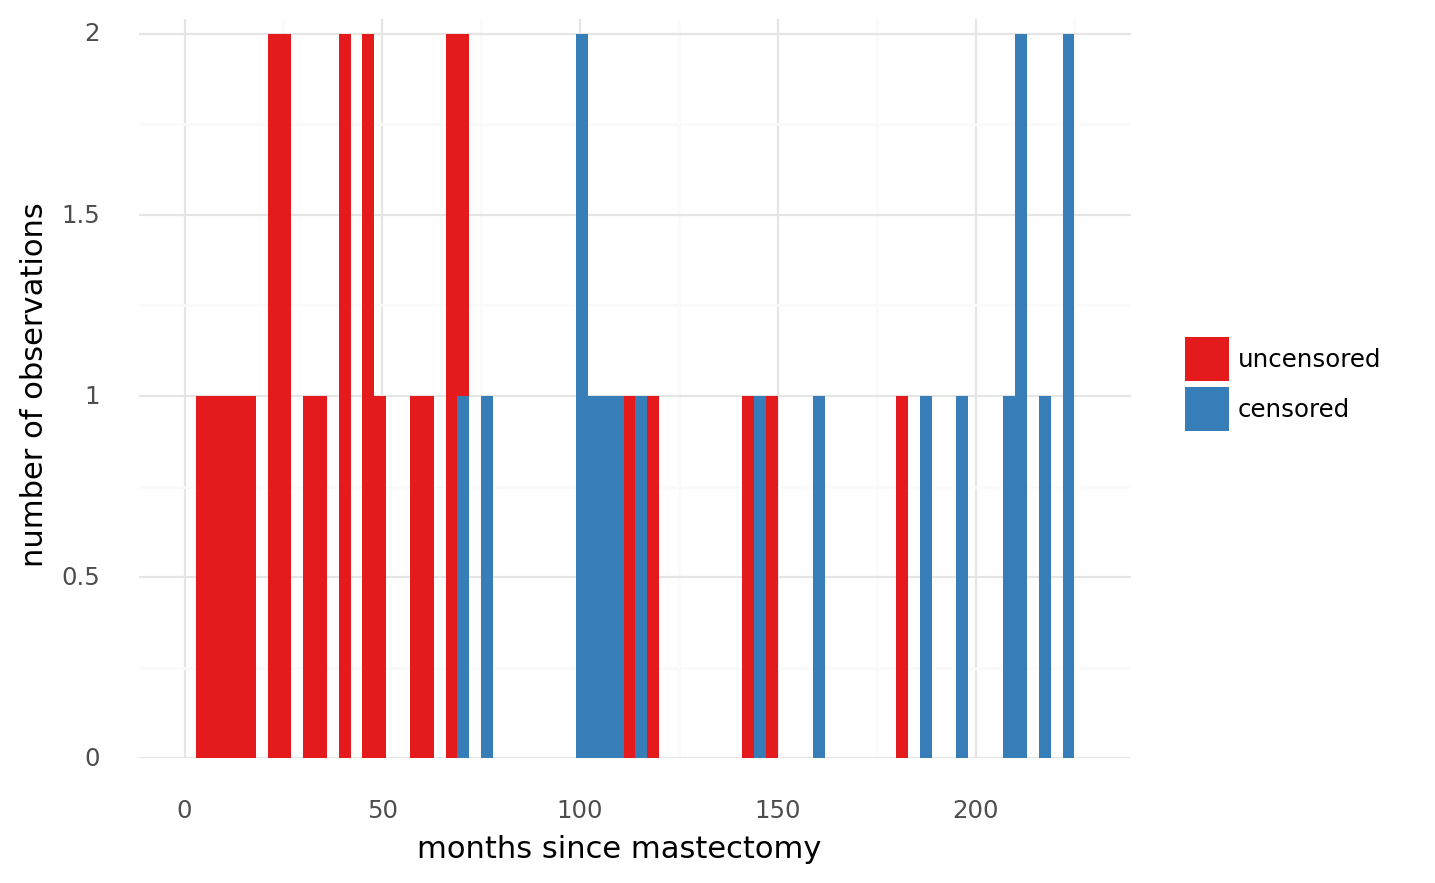

<ggplot: (352422051)>

In [13]:
(
    gg.ggplot(df, gg.aes(x="time"))
    + gg.geom_histogram(gg.aes(fill="factor(1- event)"), breaks=interval_bounds)
    + gg.scale_fill_brewer(
        type="qual", palette="Set1", labels=("uncensored", "censored")
    )
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(legend_title=gg.element_blank())
    + gg.labs(x="months since mastectomy", y="number of observations")
)

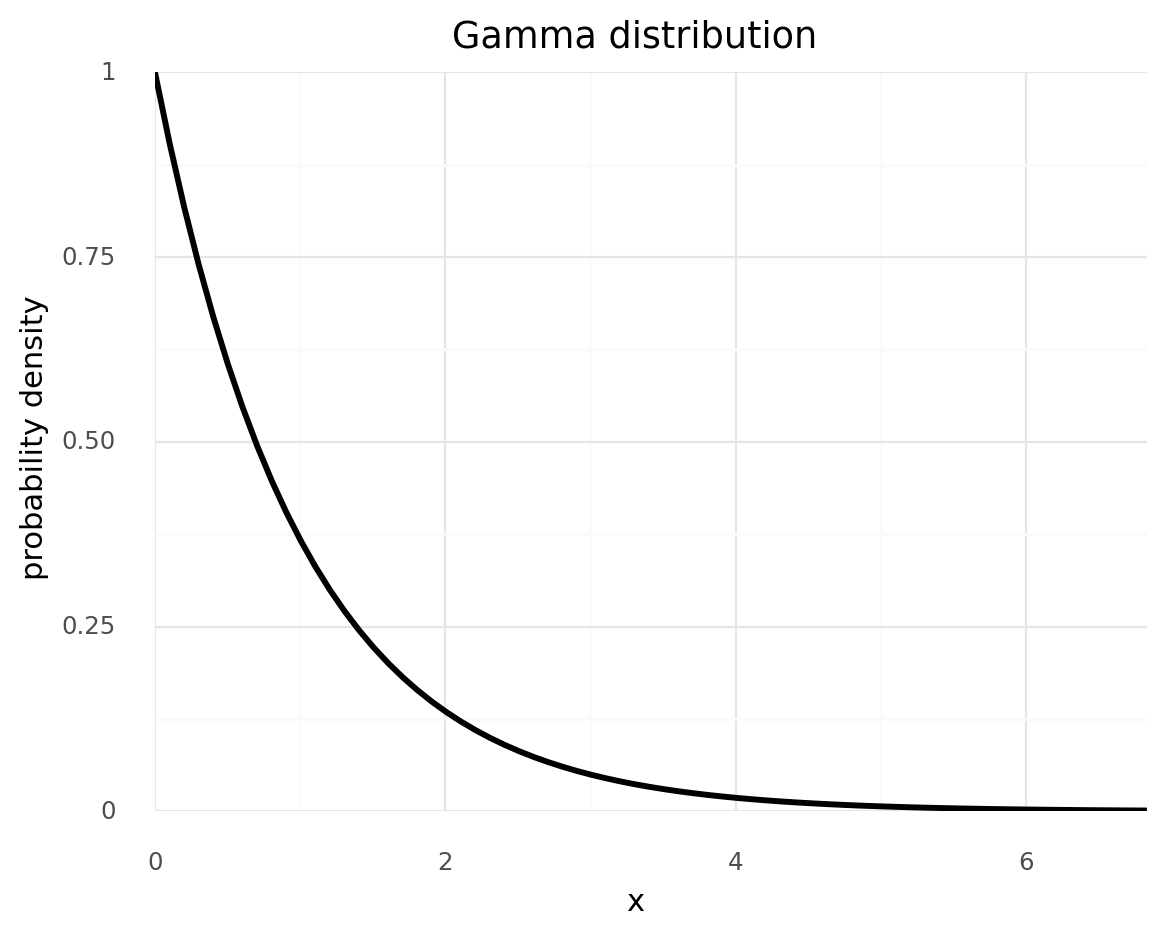

<ggplot: (364509049)>

In [52]:
x = np.linspace(0, 20, 200)
y = st.gamma.pdf(x, 1, scale=1.0 / 1)
gamma_plot_data = pd.DataFrame({"x": x, "y": y})
gamma_plot_data = gamma_plot_data[gamma_plot_data.y > 0.001]
(
    gg.ggplot(gamma_plot_data, gg.aes("x", "y"))
    + gg.geom_line(group="a", size=1.2)
    + gg.scale_x_continuous(expand=(0, 0, 0, 0), limits=(0, np.nan))
    + gg.scale_y_continuous(expand=(0, 0, 0, 0), limits=(0, np.nan))
    + gg.labs(x="x", y="probability density", title="Gamma distribution")
)

We can now figure out how to fit the model using MCMC simulation.
The piecewise-constant proportional hazard model is closely related to a Poisson regression model.
"The models are not identical, but their likelihoods differ by a factor that depends only on the observed data and not the parameters $\beta$ and $\lambda_j$.
For details, see Germán Rodríguez’s WWS 509 [course notes](http://data.princeton.edu/wws509/notes/c7s4.html)."

We will use an indicator variable based on whether or not the $i$-th subject died in the $j$-th interval

$$
d_{i,j} =
\begin{cases}
  1 &\text{if subject } i \text{ died in interval } j \\
  0 &\text{otherwise}
\end{cases}
$$

In [14]:
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)
death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event

Also, define $t_{i,j}$ to be the amount of time the $i$-th subject was at risk in the $j$-th interval.

In [16]:
exposure = (
    np.greater_equal.outer(df.time.to_numpy(), interval_bounds[:-1]) * interval_length
)
exposure[patients, last_period] = df.time - interval_bounds[last_period]

In [53]:
with pm.Model() as model:
    λ0 = pm.Gamma("λ0", 1.0, 1.0, shape=n_intervals)

    β = pm.Normal("β", 0, sigma=5)

    λ = pm.Deterministic("λ", tt.outer(tt.exp(β * df.metastized), λ0))
    μ = pm.Deterministic("μ", exposure * λ)

    obs = pm.Poisson("obs", μ, observed=death)

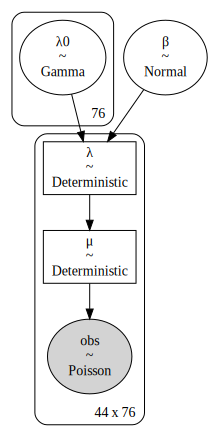

In [54]:
pm.model_to_graphviz(model)

In [55]:
with model:
    trace = pm.sample(
        1000, init="advi", n_init=50000, tune=1000, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 20400
Interrupted at 20,399 [40%]: Average Loss = 937.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, λ0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.


In [56]:
trace_az = az.from_pymc3(trace=trace, model=model)

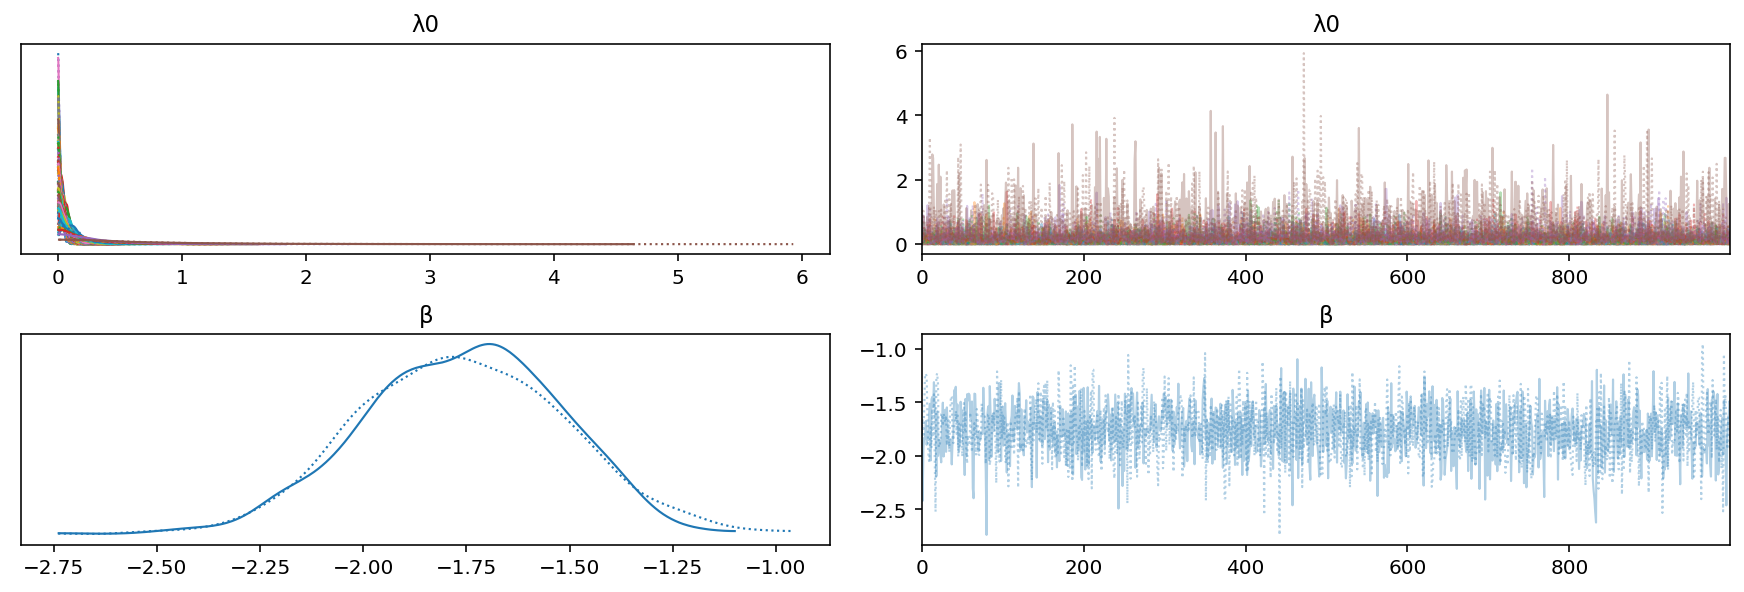

In [64]:
az.plot_trace(trace_az, var_names=["λ0", "β"]);

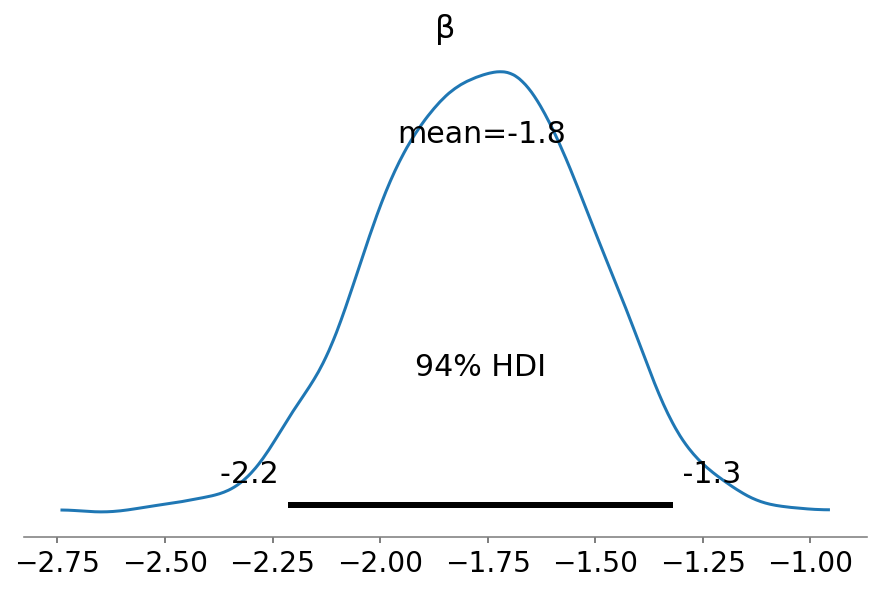

In [65]:
az.plot_posterior(trace_az, var_names="β");

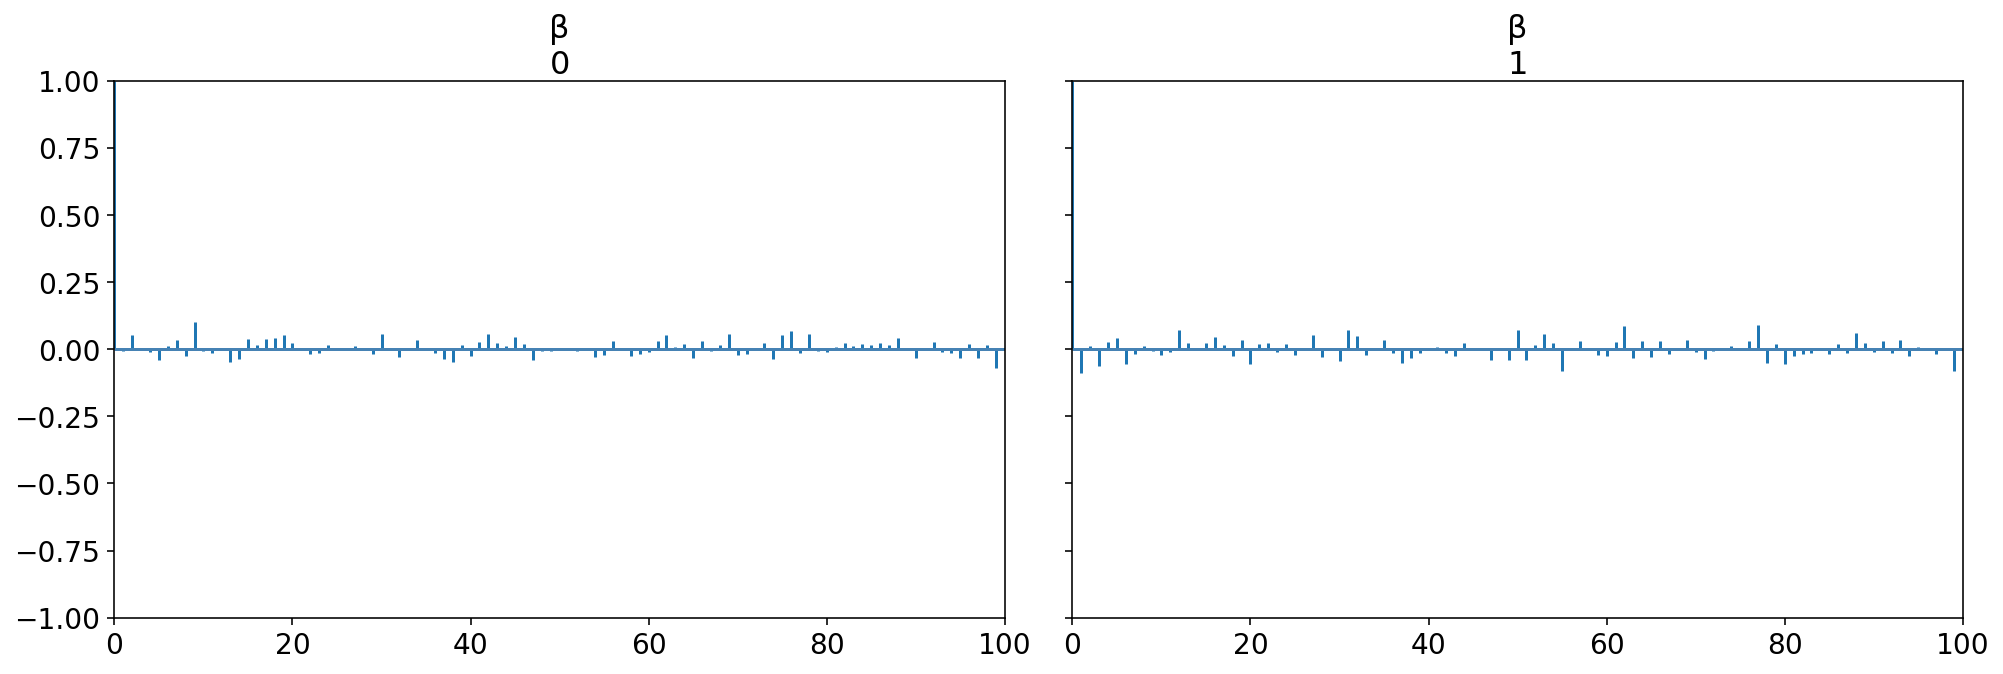

In [66]:
az.plot_autocorr(trace_az, var_names="β");

## Analysis of coefficients

We will now examine the effect of metatstization on the cumulative hazard function and survival function.

In [67]:
base_hazard = trace["λ0"]
met_hazard = trace["λ0"] * np.exp(np.atleast_2d(trace["β"]).T)

In [82]:
def cum_hazard(hazard: np.ndarray) -> np.ndarray:
    return (interval_length * hazard).cumsum(axis=-1)


def survival(hazard: np.ndarray) -> np.ndarray:
    return np.exp(-cum_hazard(hazard))


def build_summary_dataframe(
    x: np.ndarray,
    hazard: np.ndarray,
    f: Callable,
    hdi_prob: float = 0.89,
) -> pd.DataFrame:
    hazard_mean = f(hazard.mean(axis=0))
    hazard_hpd = az.hpd(f(hazard), hdi_prob=hdi_prob)

    plot_data = pd.DataFrame(
        {
            "x": x,
            "hazard_mean": hazard_mean,
            "hpd_low": hazard_hpd[:, 0],
            "hpd_high": hazard_hpd[:, 1],
        }
    )

    return plot_data

In [87]:
hazard_plot_data = pd.concat(
    [
        build_summary_dataframe(interval_bounds[:-1], base_hazard, f=cum_hazard).assign(
            metastized=False
        ),
        build_summary_dataframe(interval_bounds[:-1], met_hazard, f=cum_hazard).assign(
            metastized=True
        ),
    ]
)

hazard_plot_data.head()

,x,hazard_mean,hpd_low,hpd_high,metastized
0,0,0.054854,0.000010,0.122975,False
1,3,0.167472,0.020913,0.291957,False
2,6,0.280649,0.079634,0.456071,False
3,9,0.395625,0.150241,0.600450,False
4,12,0.512123,0.237538,0.762393,False


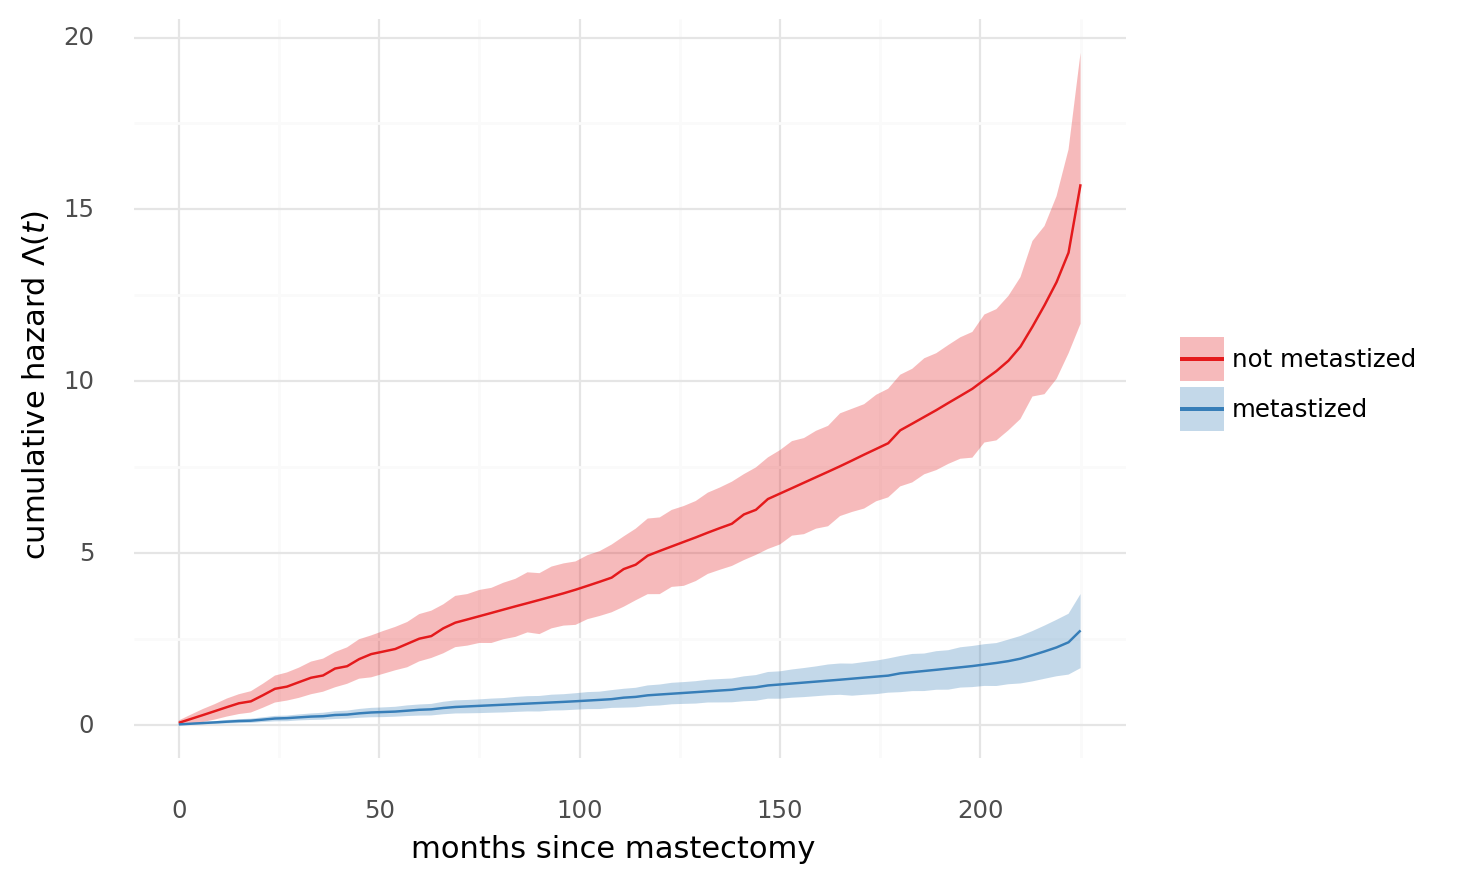

(<ggplot: (356960826)>,)

In [92]:
pal_kwargs = {
    "type": "qual",
    "palette": "Set1",
    "labels": ("not metastized", "metastized"),
}
(
    gg.ggplot(hazard_plot_data, gg.aes(x="x"))
    + gg.geom_ribbon(
        gg.aes(ymin="hpd_low", ymax="hpd_high", fill="metastized"), alpha=0.3
    )
    + gg.geom_line(gg.aes(y="hazard_mean", color="metastized"))
    + gg.scale_color_brewer(**pal_kwargs)
    + gg.scale_fill_brewer(**pal_kwargs)
    + gg.theme(legend_title=gg.element_blank())
    + gg.labs(x="months since mastectomy", y=r"cumulative hazard $\Lambda(t)$")
),